# <center> **DataChallenge : Functional Anomalies Detection**
## <center> Matthieu DESSE

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
PATH_TO_GOOGLE_DRIVE_FOLDER = '/content/drive/My Drive/05_Datachallenge/02_AD'
os.chdir(PATH_TO_GOOGLE_DRIVE_FOLDER)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Imports

In [2]:
import pandas as pd
import numpy as np
import glob

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from scipy.stats import moment
from scipy.stats import kurtosis

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [4]:
!pip install pyod

     |████████████████████████████████| 102kB 2.7MB/s ta 0:00:011
     |████████████████████████████████| 2.1MB 10.7MB/s 
  Created wheel for pyod: filename=pyod-0.7.8.2-cp36-none-any.whl size=104997 sha256=d52420e02d5912c826c45184b9997eb92b72cec06570efada11d52178d64edd5
  Stored in directory: /root/.cache/pip/wheels/28/38/ec/0ecbcd67faeb595ac0dbd9b5f85d5c5bdcb4573819e65240fe
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=a8d9e16cbca55f127ca4eaf63d4a6616175bc714507bb7320d9a2fb8dc5dab63
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167157 sha256=0b2bde96b036efdd1ba6727a64eb9ff02a74992dc8ac1de4fab5212a1cb08809
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [ ]:
path = '01_data/'
train_data = 'airbus_train.csv'
test_data = 'airbus_test.csv'

In [6]:
%time xtrain = np.loadtxt(path+train_data, delimiter= ' ')
print(xtrain.shape)
%time xtest = np.loadtxt(path+test_data, delimiter= ' ')
print(xtest.shape)

CPU times: user 59.4 s, sys: 8.83 s, total: 1min 8s
Wall time: 1min 13s
(1677, 61440)
CPU times: user 1min 24s, sys: 8.53 s, total: 1min 33s
Wall time: 1min 39s
(2511, 61440)


## Some useful functions

In [ ]:
def visualise_random_series(x:np.array, b:int)->plt.figure:
  """
  Plot on the same graphic, b (parameters) time series.

  """

  idx_arr = np.random.randint(low=1, high=100, size=5 )
  
  plt.figure(figsize=(17,5))
  for i in idx_arr:
    plt.plot(x[i])
    plt.legend(idx_arr)
  plt.show()


In [ ]:
stat_moment_name = ['mean', 'var', 'std', 'min', 'max', 'kurt', 'moment3']

In [ ]:
def statistical_standards(X:np.array)->np.array:
  
  """
  Return array with statistical values of all time series like mean, var, ...
  """

  arr_mean = np.mean(X, axis=1).reshape(-1,1)
  arr_var = np.var(X, axis=1).reshape(-1,1)
  arr_std = np.std(X, axis=1).reshape(-1,1)
  arr_min = np.min(X, axis=1).reshape(-1,1)
  arr_max = np.max(X, axis=1).reshape(-1,1)
  arr_kurt = np.array(kurtosis(X, axis=1)).reshape(-1,1)
  moment3 = moment(X, axis=1, moment=3).reshape(-1,1)
  

  result = np.concatenate((arr_mean, arr_var, arr_std, arr_min, arr_max, arr_kurt, moment3), axis=1)

  return result

In [ ]:
def statistical_moments(X:np.array, order=int)->np.array:
  
  """
  Return array with statistical moment of all time series like mean, var, ...
  """
  
  result = []
  for i in range(3, order+1):
    momenti = moment(X, axis=1, moment=i).reshape(-1,1)
    result.append(momenti)

  return np.concatenate(result, axis=1)

In [ ]:
def data_split_validation(X:np.array, size:float)-> np.array:
  """
  Return train and validation samples with a random random_state
  """
  random_state = np.random.randint(100, 10000)
  
  X_train, X_test = train_test_split(X, test_size=size, random_state=random_state)
  
  return X_train, X_test

In [ ]:
def submit(model, title:str, xtest:np.array):
  """
  Save the anomaly scores to file
  """
  sscore = -model.score_samples(xtest)
  np.savetxt('03_submission/'+title, sscore, fmt = '%1.6f', delimiter=',')

  print('size of saving file : {}'.format(sscore.shape), 'The file'+title+'has been saved')

## Data Mining

First, we will check the quality of our data and visualise it.

In [13]:
print('Number of missing value = {}'.format(pd.DataFrame(xtrain).isnull().sum().sum()))

Number of missing value = 0


Let's visualise random times series




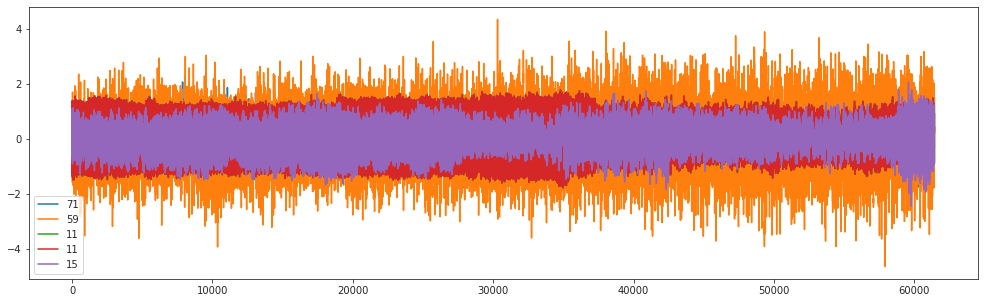

In [14]:
visualise_random_series(xtrain, 4)

We can see that these random time series are around zero with different magnitudes. It highlights the effort variations applied on the helicopter during a fly. 

But this visualisation is very difficult to interpret and generalize. We will adopt an statistical overview through standard metrics (mean, var, std ...)

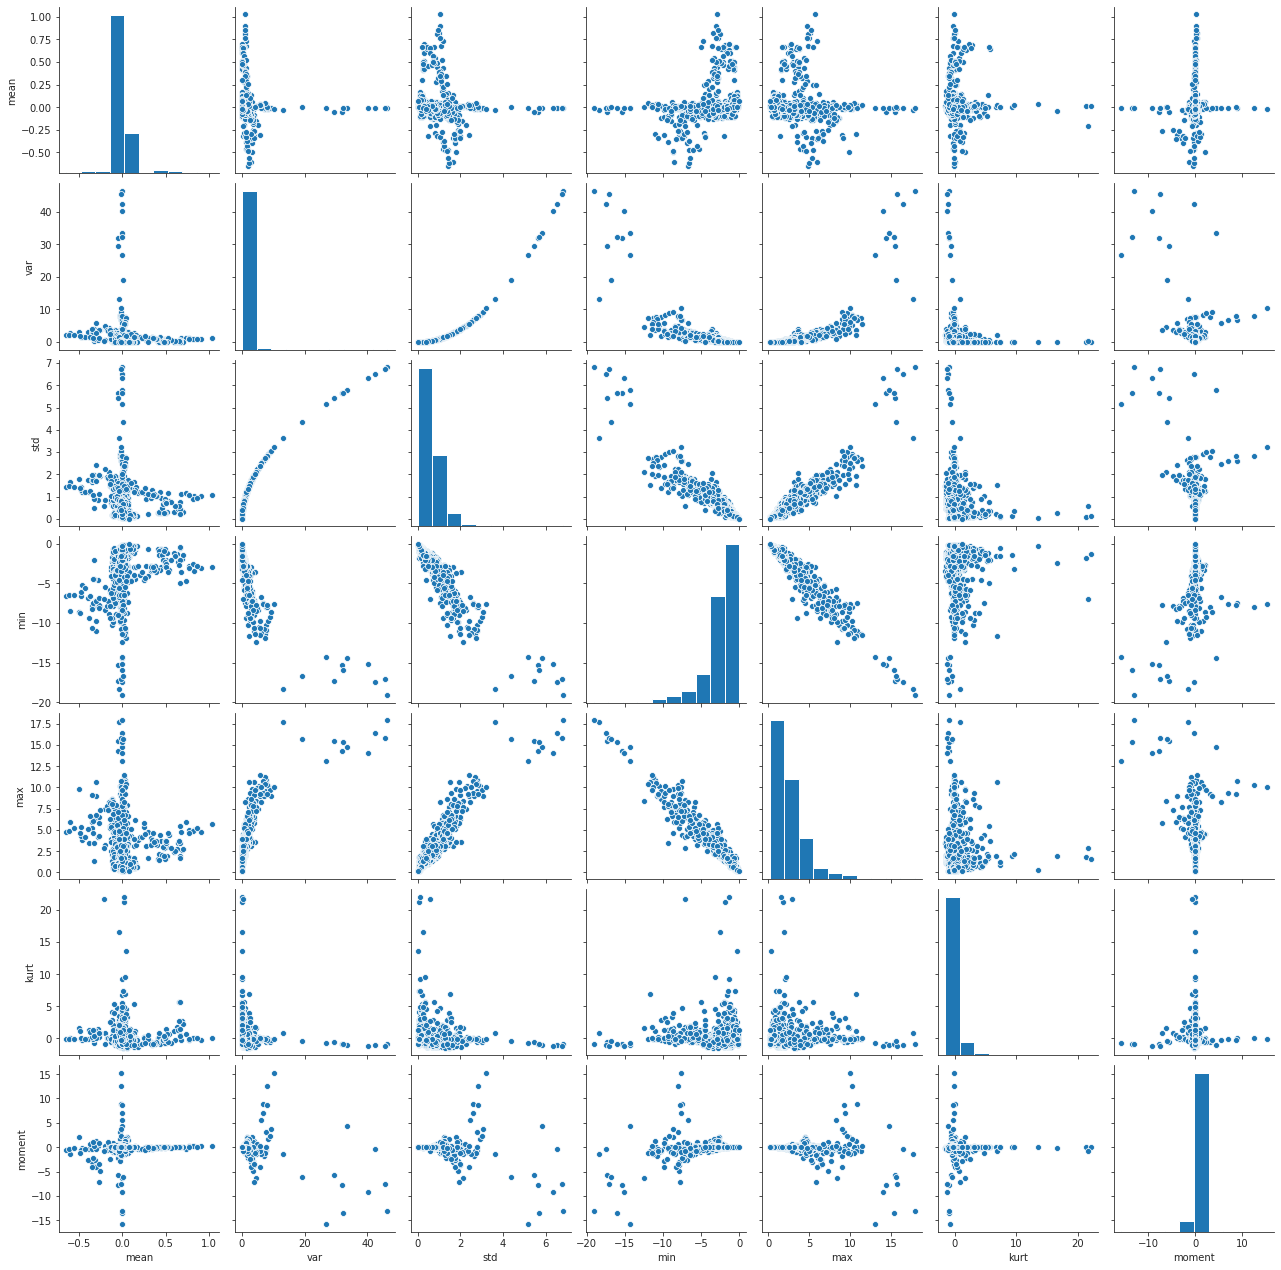

In [21]:
df = pd.DataFrame(statistical_standards(xtrain))
df.columns = stat_moment_name
sns.pairplot(df)

Pairplot view gives us more informations than the previous view ! 

- As we have previously seen, most of values are around zero (cf : mean, max, min distributions). Another useless thing but obvious, we find the relation between var and std.

- Thanks to these plots, we can observe several clusters. Indeed, most of plots are composed by two main clusters : 
  1. One cluster very dense, that is composed by the majority of observations.
  2. A second cluster, less dense with probably skewed observations.

  We will decline our approaches along three main axis :
  1.  Building a model from times series with standard algorithms as LOF, isolation forest and one SVM.
  2. Building a model through statistical moments of each time series.

## Axis 1 : standard approach

### Dimension reduction and distance algotithm (PCA + LOF)

We will follow the approach proposed by Pavlo. The idea is to reduce the dimension of our dataset. Indeed, we are in the case we are the number of features is greater than number of samples. After using PCA, we will use LOF algorithm.

In [ ]:
X_train, X_test = data_split_validation(xtrain, 0.2)

In [ ]:
#PCA transformation
pca1 = PCA(n_components = 0.3, whiten = True, random_state = 12345)
X_train_pca = pca1.fit_transform(X_train)

# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 10, contamination = 'auto', leaf_size=10,novelty = True, n_jobs=-1)
lof1.fit(X_train_pca)

In [ ]:
xtest_pca = pca1.transform(xtest)
submit(lof1, 'xtrain_pca10_lof10', xtest_pca)

In tuning PCA and LOF parameters we obtain a score between 0.59 and 0.70. 

### Dimension reduction + Isolation Forest

In [ ]:
isf = IsolationForest(n_estimators=2000, max_samples='auto', contamination='auto', 
                      bootstrap=True, n_jobs=-1, behaviour='deprecated', 
                      random_state=12345, verbose=0, warm_start=False)

In [ ]:
%time isf.fit(X_train_pca)

CPU times: user 3.63 s, sys: 368 ms, total: 4 s
Wall time: 3.43 s


IsolationForest(behaviour='deprecated', bootstrap=True, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=2000,
                n_jobs=-1, random_state=12345, verbose=0, warm_start=False)

In [ ]:
xtest_pca = pca1.transform(xtest)
submit(isf, 'xtrain_pca10_isf2000', xtest_pca)

size of saving file The filextrain_pca10_isf2000has been saved


### One SVM

In [ ]:
svm = OneClassSVM(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5,
                              shrinking=True, cache_size=200, verbose=False, max_iter=-1)
svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

## Axis 2 : statistical moments

Now, we have change our approach in training our model with another dataset. Indeed, we will train our model through main statistical measures of each time series :
- mean
- variance
- standard deviation
- min and max
- kurtosis
- moment 3

We underline that the dataset seems low contaminated. Therefore, we have to control this central hyper-parameters. 

In [22]:
X_train = statistical_standards(xtrain)
X_test = statistical_standards(xtest)
X_train.shape, X_test.shape

((1677, 7), (2511, 7))

## Isolation Forest

In [ ]:
isf = IsolationForest(n_estimators=5000, max_samples=0.99, contamination=0.0, max_features=1.0, 
                      bootstrap=True, n_jobs=-1, behaviour='deprecated', random_state=1245, verbose=1, warm_start=False)
%time isf.fit(X_train)

submit(isf, 'xtrain_stat_std_isf7000_cont_0_maxsamples0.99', X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    9.2s finished


CPU times: user 15.4 s, sys: 967 ms, total: 16.4 s
Wall time: 13.9 s
size of saving file : (2511,) The filextrain_stat_std_isf7000_cont_0_maxsamples0.99has been saved


### LOF

In [ ]:
lof = LocalOutlierFactor(n_neighbors=10, algorithm='auto', leaf_size=20, metric='sqeuclidean',
                         metric_params=None, contamination=0.001, novelty=True, n_jobs=-1)
%time lof.fit(X_train)
submit(lof, 'xtrain_stat5_lof10_contam0.001', X_test)

CPU times: user 144 ms, sys: 17 ms, total: 161 ms
Wall time: 179 ms
size of saving file The filextrain_stat5_lof10_contam0.001has been saved


### One SVM

In [ ]:
svm = OneClassSVM(kernel='rbf', degree=3, gamma='auto', coef0=1, tol=0.001, nu=0.001,
                              shrinking=True, cache_size=200, verbose=False, max_iter=-1)

svm.fit(X_train)
submit(svm, 'xtrain_stat15_oneSVM-rbf_deg3_tol0.001_nu0.001_coef1', X_test)

size of saving file : (2511,) The filextrain_stat15_oneSVM-rbf_deg3_tol0.001_nu0.001_coef1has been saved


### Robust method 

In [ ]:
from sklearn.covariance import EllipticEnvelope
env = EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=0.7,
                       contamination=0.001, random_state=12356)
env.fit(X_train)
submit(env, 'xtrain_stat5_env_cont0.001_frac0.7', X_test)

size of saving file The filextrain_stat5_env_cont0.001_frac0.7has been saved


This model is not efficient enough because of its strong hypothesis (gaussian).

## PYOD

In [ ]:
from pyod.models.hbos import HBOS
hbos = HBOS(n_bins=20, alpha=0.1, tol=0.005, contamination=0.001)
hbos.fit(X_train)
submit(env, 'xtrain_stat5_hbos', X_test)

size of saving file The filextrain_stat5_hboshas been saved


This approach is better than the previous one. That means our metrics syntheses more informations. 

## Axis 3 : Stacking

We have seen in the previous part, that using commun statistical metrics are more efficient than time series itself. First, we will add severalm statistical moment to our dataset, then will use the previous submission files with a score higher than 0.7

In [ ]:
path = "03_submission/"

all_files = glob.glob(os.path.join(path, "0.7*"))

all_df = []
for f in all_files:
    print(f)
    df = pd.read_csv(f, sep=',', header=None)
    all_df.append(df)

all_df[0].shape 

merged_df = pd.concat(all_df, ignore_index=True, axis=1, sort=True)

03_submission/0.7032_xtrain_mean_lof_5
03_submission/0.713_xtrain_stat_mom_5feat_lof_10
03_submission/0.7237_xtrain_stat_mom_5feat_isf
03_submission/0.723_xtrain_stat5_isf2000
03_submission/0.701_xtrain_stat5_oneSVM-rbf_deg3
03_submission/0.71310_xtrain_stat_mom_5feat_lof_5.csv
03_submission/0.7384_xtrain_stat_std_isf5000_cont_0.01
03_submission/0.737989_xtrain_stat_std_isf10000_cont_0.001
03_submission/0.7384_xtrain_stat_std_isf5000_cont_0.0001_maxsamples0.99
03_submission/0.73846_xtrain_stat_std_isf7000_cont_0_maxsamples0.99
03_submission/0.7298_xtrain_stat5_lof20_contam0.001
03_submission/0.7136_xtrain_stat5_lof10_contam0.001
03_submission/0.7139_xtrain_stat5_lof10_contam0.001
03_submission/0.7813_xtrain_stat5_oneSVM-rbf_deg3_coef1
03_submission/0.7813_xtrain_stat5_oneSVM-rbf_deg3_coef3
03_submission/0.7813415_xtrain_stat5_oneSVM-rbf_deg3_tol0.0001_nu0.1
03_submission/0.79246_xtrain_stat5_oneSVM-rbf_deg3_tol0.001_nu0.01_coef1
03_submission/0.7930_xtrain_stat5_oneSVM-rbf_deg3_tol0.00

In [ ]:
X_train_merged = merged_df.to_numpy()
X_train_merged.shape

(2511, 19)

In [ ]:
stacking = IsolationForest(n_estimators=7000, max_samples=0.7, contamination=0.001, 
                      bootstrap=True, n_jobs=-1, behaviour='deprecated', 
                      random_state=12345, verbose=0, warm_start=False)
%time stacking.fit(X_train)

CPU times: user 29.9 s, sys: 4.27 s, total: 34.2 s
Wall time: 28.6 s


IsolationForest(behaviour='deprecated', bootstrap=True, contamination=0.001,
                max_features=1.0, max_samples=0.7, n_estimators=7000, n_jobs=-1,
                random_state=12345, verbose=0, warm_start=False)

In [ ]:
submit(stacking, 'test_stack_isf', X_train)

size of saving file : (2511,) The filetest_stack_isfhas been saved


In [ ]:
svm = OneClassSVM(kernel='rbf', degree=3, gamma='auto', coef0=1, tol=0.001, nu=0.001,
                              shrinking=True, cache_size=200, verbose=False, max_iter=-1)

svm.fit(X_train)
submit(svm, 'xtrain_stat15_oneSVM-rbf_deg3_tol0.001_nu0.001_coef1', X_train)

size of saving file : (2511,) The filextrain_stat15_oneSVM-rbf_deg3_tol0.001_nu0.001_coef1has been saved


We observe that our result are around 0.73. We can conclude that we don't have more informations in these metrics and we have to choose anothers.

## Conclusion - improvment axis

We have seen with this challenge that sometimes it is more relevant to use statistical metrics than the time series itself. We can explain it because we observe accelerations of an helicopter part (supposed a rotor). We have a lot of recorded informations because our time scale is very small.

The best model I had is the one SVM with statistical metrics with a score of 0.79.

I have two main improvment axis :
- add statistical / ML metrics as AIC, BIC. The idea will be train a model for each series and extract metrics from it.
- create a baseline time series and compare it with the dataset (GAN, VAE)

